# Walleye Capital / Quantic - Pandas Coding Test

Below, you will be asked to complete a series of coding tasks of ascending complexity. Please consider the following criteria:
- You have thirty minutes to complete this test.
- You will be judged primarily for the quality of code, not your knowledge of quant topics. High quality code is legible, standard-conformant, testable, well-documented, and of course correct.
- You may import any additional libraries or look up definitions, APIs, etc. as you deem necessary.
- Feel free to skip any questions you get stuck on, although some of them are necessary to do the later questions.
- Completing as much of the test as you can in the allotted time is more valuable than a clever and optimally performant solution.
- I am available as a resource for any questions as you go.

# Introduction / Setup

In [304]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from tqdm import tqdm

# feel free to import anything else you might want.

In [305]:
import requests, zipfile, io
r = requests.get('https://github.com/wwang-walleye/walleye-coding-test-data/blob/main/ct-data.zip?raw=true') 
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

univ = pd.read_csv(z.open('coding-test-u.csv'))
brtn = pd.read_csv(z.open('coding-test-bd1.csv'))

Below, please find two dataframes as follows:

`univ` is a dataframe which specifies an investment universe over 2 years of contiguous trading days. The columns have the following definitions:
1. `date` - hopefully self-explanatory.
2. `secid` - a unique identifier for a given company (analogous to ticker).
3. `gic2` - a discrete variable indicating sector membership. All secid with the same value for `gic2` are members of the same sector.

The rows matching each `date` in `univ` indicate that a given `secid` is a constituent of the universe on that `date`.

In [306]:
univ.head()

,date,secid,gic2
0,2018-06-27,4717,20
1,2018-06-27,3905,40
2,2018-06-27,3107,20
3,2018-06-27,605,55
4,2018-06-27,4656,35


`brtn` is a dataframe which specifies the trailing 1-day return of a given `secid` on a given `date`. Assume that the data in `brtn` is complete (i.e., it is not missing any trading days). Note that on a given date, any `secid` in the `brtn` dataframe may or may not be in the universe (i.e., the set of stocks in univ is a subset of the set of stocks in brtn on any given date).

In [307]:
brtn.head()

,date,secid,bd1
0,2017-06-29,2741,-0.017449
1,2017-06-29,4717,0.106220
2,2017-06-29,3905,0.027050
3,2017-06-29,3107,0.055955
4,2017-06-29,605,0.060428


# Basic pandas operations (2 points each)

Please write some code to perform the following basic tasks:
1. Print the data types in `univ` and `brtn`. Does anything look off? If so, fix that issue in-place (i.e., mutate `univ` and `brtn` accordingly).
2. Set an appropriate index on `univ` and `brtn`, and then sort by the index. Do this in-place (i.e., overwrite `univ` and `brtn`).
3. Count the number of securities in `univ` on each date.
4. Count the number of securities in each sector (`gic2`) on each date.
5. Plot the number of securities in each sector through time in an appropriate way.
6. Compute the average return for each stock in the universe on each date.

In [308]:
# Print the dtypes for both dataframes.
# Do any of the data types look inappropriate? If so, please fix them. (Hint: pandas will display string types as `object`).
univ['date']=pd.to_datetime(univ['date'])
brtn['date']=pd.to_datetime(brtn['date'])

In [309]:
# Set an appropriate index on univ and brtn, then sort by this index. 
# A good index should uniquely identify every row.
univ.set_index(['date','secid'],inplace=True)
brtn.set_index(['date','secid'],inplace=True)
univ.sort_index(inplace=True)
brtn.sort_index(inplace=True)

In [310]:
# Show the n of umbersecurities in univ on each date
univ.reset_index().groupby(['date'])[['secid']].count()

,secid
date,
2018-06-27,1436
2018-06-28,1438
2018-06-29,1439
2018-07-02,1440
2018-07-03,1446
...,...
2019-06-24,1341
2019-06-25,1340
2019-06-26,1350


In [311]:
# Show the number of securities in each sector on each date
univ.groupby(['date'])['gic2'].value_counts().unstack()

gic2,10,15,20,25,30,35,40,45,50,55,60
date,,,,,,,,,,,
2018-06-27,122,88,188,223,69,195,192,265,12,53,29
2018-06-28,121,87,188,224,69,196,190,268,13,53,29
2018-06-29,122,86,189,222,69,198,191,267,13,53,29
2018-07-02,119,86,190,221,69,199,190,270,13,53,30
2018-07-03,119,89,191,222,68,200,192,269,13,53,30
...,...,...,...,...,...,...,...,...,...,...,...
2019-06-24,79,84,181,181,63,183,175,237,76,54,28
2019-06-25,79,84,181,184,63,183,173,236,75,54,28
2019-06-26,81,87,183,184,65,184,170,236,78,53,29


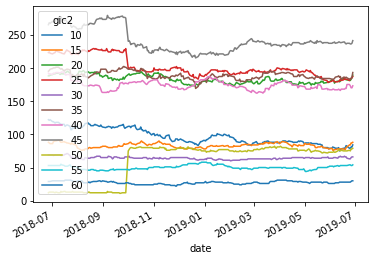

In [312]:
# Plot the number of securities in each sector over time.
univ.groupby(['date'])['gic2'].value_counts().unstack().plot()

In [313]:
# Compute the average return for all stocks in `univ` by date.
brtn.join(univ).groupby('date')['bd1'].mean()

date
2017-06-29   -0.001711
2017-06-30    0.003829
2017-07-03    0.010405
2017-07-05   -0.000944
2017-07-06   -0.004804
                ...   
2019-06-24   -0.004748
2019-06-25   -0.003538
2019-06-26    0.000339
2019-06-27    0.010953
2019-06-28    0.007989
Name: bd1, Length: 503, dtype: float64

# More complex tasks (4 points each)
1. Write a function that does the following:
    1. Given a date `dt`, finds the subset of stocks in `univ` on `dt`. 
    2. Get the rows in `brtn` for all dates between `dt` and the 1 year prior to `dt` that match the universe as of `dt` you found in (1.1).
    3. Returns a DataFrame which contains the daily returns of all stocks in `univ` on `dt` for each of these dates found in (1.2).

2. Write a function that computes the 1-year daily beta as of `dt` for every stock in `univ` against the equally-weighted universe (i.e., the average return). Beta is a measure of risk, and it indicates how much a stock's returns covary with the universe's returns. The formula for beta is: $Beta(A,B) = Covar(A,B) / Var(B)$

3. Compute the 1-year total return for each stock in the universe as of some `dt`. Make a chart comparing this total return figure to the betas you produced by running `get_betas()`.

In [314]:
# trailing year's daily returns for the univ as of `dt`
def get_univ_brtn(dt: pd.Timestamp) -> pd.DataFrame:
    """ Returns the trailing calendar year of returns
    
    Parameters
    ----------
    dt : pd.Timestamp

    Returns
    -------
    ub : pd.DataFrame or pd.Series

    """

    subset_univ = univ.loc[dt]
    subset_brtn = brtn[dt-pd.DateOffset(years=1): dt]
    ub = subset_univ.join(subset_brtn).loc[:, 'bd1']

    return ub, subset_univ

ub, _ = get_univ_brtn(pd.Timestamp('2018-06-27'))
ub

date        secid
2017-06-29  7        0.075851
            8       -0.022878
            9       -0.040154
            10      -0.044911
            11       0.063505
                       ...   
2018-06-27  4794     0.035959
            4797     0.089798
            4802     0.080961
            4803     0.273783
            4805    -0.083496
Name: bd1, Length: 357702, dtype: float64

In [315]:
# compute 1-year trailing beta to the universe as of `dt`
def get_betas(univ_brtn: pd.DataFrame) -> pd.Series:
    """ Returns the 1-year trailing beta to the cross-sectional mean.

    Parameters
    ----------
    univ_brtn: pd.DataFrame

    Returns
    -------
    betas : pd.Series
        The beta of each security to the daily cross-sectional mean in `univ_brtn`
    """
    def _get_betas(df):
        # https://stackoverflow.com/questions/39501277/efficient-python-pandas-stock-beta-calculation-on-many-dataframes
        # first column is the market
        X = df.values[:, [-1]]
        # prepend a column of ones for the intercept
        X = np.concatenate([np.ones_like(X), X], axis=1)
        # matrix algebra
        b = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(df.values[:, :-1])
        return pd.Series(b[1], df.columns[:-1], name='Beta')

    combined_return = univ_brtn.unstack().join(brtn.join(univ).groupby('date')['bd1'].mean()).dropna()
    
    betas = _get_betas(combined_return)

    return betas
    
betas = get_betas(ub)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


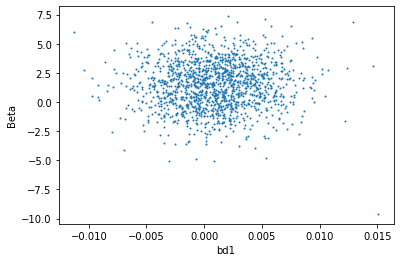

In [316]:
# plot the betas on a given date against the trailing 1-year return as of that date
pd.DataFrame(betas).join(ub.reset_index().set_index('date').groupby('secid').mean()).plot.scatter(x='bd1',y='Beta',s=1)

# Putting it together (10 points in total)

1. Write a function that does the following:
    1. Gets the betas as of a given date.
    2. Produces the 3-month, 6-month, and 12-month trailing return as of that date *(NB: there are 252 trading days in a year)*.
    3. Adjusts the trailing returns for beta and sector (`gic2`) in a way that you think is reasonable.
    4. Normalizes the resulting signals in a way you think is reasonable.
    5. Produces a 4th signal that combines the 3 signals above in a reasonable way.

3. Find the last date of each month in your data set, and produce the signal for each of those month-end dates.

4. For extra credit, perform some perfunctory analysis on your result.

In [317]:
def make_signals(dt: pd.Timestamp) -> pd.DataFrame:
    """
    Parameters
    ----------
    dt : pd.Timestamp

    Returns
    -------
    sigs : pd.DataFrame
    """
    ub, subset_univ = get_univ_brtn(dt)

    trailing_return_12_mo = ub.reset_index().set_index('date').groupby('secid').mean().rename({'bd1':'mom_12'},axis=1)
    trailing_return_6_mo = ub[dt-pd.DateOffset(months=6): dt].reset_index().set_index('date').groupby('secid').mean().rename({'bd1':'mom_6'},axis=1)
    trailing_return_3_mo = ub[dt-pd.DateOffset(months=3): dt].reset_index().set_index('date').groupby('secid').mean().rename({'bd1':'mom_3'},axis=1)
    betas = get_betas(ub)
    merged_df = pd.concat([trailing_return_12_mo, trailing_return_6_mo, trailing_return_3_mo, betas],axis=1).join(subset_univ)
    one_hot_gic2 = pd.get_dummies(merged_df['gic2'], prefix='gic2_')
    merged_df = merged_df.join(one_hot_gic2)
    merged_df.drop(columns=['gic2'],inplace=True)

    for col in ['mom_12','mom_6','mom_3']:
        y = merged_df[col]
        X = merged_df.iloc[:, 3:]
        residual=sm.OLS(y, X).fit().resid
        merged_df[f'{col}_residual']=residual
    merged_df['combined_mom'] = merged_df['mom_3_residual'] * 0.5 + merged_df['mom_6_residual'] * 0.3 + merged_df['mom_12_residual'] * 0.2
    sigs = pd.DataFrame(merged_df['combined_mom'])
    sigs['date'] = dt
    sigs=sigs.reset_index().rename({"index":"secid"},axis=1)
    return sigs

make_signals(pd.Timestamp('2018-06-27'))

,secid,combined_mom,date
0,7,0.003314,2018-06-27
1,8,-0.006086,2018-06-27
2,9,-0.003236,2018-06-27
3,10,0.005188,2018-06-27
4,11,0.002484,2018-06-27
...,...,...,...
1431,4794,-0.002485,2018-06-27
1432,4797,0.002070,2018-06-27
1433,4802,-0.004131,2018-06-27
1434,4803,-0.001331,2018-06-27


In [318]:
# Produce the set of month-end dates
month_end_date=univ.reset_index()
month_end_date['month_end'] =  pd.to_datetime(month_end_date['date'], format="%Y%m") + pd.tseries.offsets.BMonthEnd(0)
print(month_end_date['month_end'].unique())

['2018-06-29T00:00:00.000000000' '2018-07-31T00:00:00.000000000'
 '2018-08-31T00:00:00.000000000' '2018-09-28T00:00:00.000000000'
 '2018-10-31T00:00:00.000000000' '2018-11-30T00:00:00.000000000'
 '2018-12-31T00:00:00.000000000' '2019-01-31T00:00:00.000000000'
 '2019-02-28T00:00:00.000000000' '2019-03-29T00:00:00.000000000'
 '2019-04-30T00:00:00.000000000' '2019-05-31T00:00:00.000000000'
 '2019-06-28T00:00:00.000000000']


In [319]:
# Create a dataframe with the signals as of each month-end date
signal_df = pd.DataFrame()
for m_end_date in tqdm(month_end_date['month_end'].unique()):
    signal_df = signal_df.append(make_signals(pd.to_datetime(m_end_date)))


100%|██████████| 13/13 [00:13<00:00,  1.06s/it]


In [320]:
# Do some additional analysis -- what can you tell us about the signal you've created?

In [321]:
signal_df

,secid,combined_mom,date
0,7,0.003171,2018-06-29
1,8,-0.004996,2018-06-29
2,9,-0.003283,2018-06-29
3,10,0.004177,2018-06-29
4,11,0.002327,2018-06-29
...,...,...,...
1379,4785,0.003106,2019-06-28
1380,4787,0.000528,2019-06-28
1381,4794,-0.000252,2019-06-28
1382,4803,-0.001176,2019-06-28


In [322]:
import alphalens